In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA
import seaborn as sns

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.models import load_model

from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


In [2]:
def change_number(unique_lst):
    unique = pd.DataFrame(unique_lst).reset_index()
    indexes = unique['index']
    ids = unique[0]
    tuple_zip = list(zip(ids, indexes))
    dic = dict((x, y) for x, y in tuple_zip)
    reverse_dic = dict((y, x) for x, y in tuple_zip)
    return dic, reverse_dic

In [3]:
ratings2 = pd.read_csv('ratings_dessert.csv')

rating_count2 = ratings2.groupby('recipe_id')['rating'].count().reset_index()
rating_count = rating_count2.rename(columns = {'rating':'review_count'})

threshold = 10
rating_count = rating_count.query('review_count >= @threshold')
rating_count

recipe_rating = pd.merge(rating_count, ratings2, left_on='recipe_id', right_on='recipe_id', how='left')

user_count2 = ratings2.groupby('user_id')['rating'].count().reset_index()
user_count = user_count2.rename(columns = {'rating':'user_count'})
    
threshold = 10
user_count = user_count.query('user_count >= @threshold')

ratings = pd.merge(user_count, recipe_rating, left_on = 'user_id', right_on = 'user_id', how = 'inner')

ratings.to_csv('result_dessertMF.csv', index=False)

In [4]:
unique_users = list(ratings['user_id'].unique())
unique_recipe = list(ratings['recipe_id'].unique())

In [5]:

dic_user, dummy = change_number(unique_users)

ratings['user_id'] = ratings['user_id'].replace(dic_user)

In [6]:
dic_recipe, dic_recipe_reverse = change_number(unique_recipe)

ratings['recipe_id'] = ratings['recipe_id'].replace(dic_recipe)

### scale values 

In [7]:
scaler = MinMaxScaler()
ratings['rating'] = ratings['rating'].values.astype(float)
rating_scaled = pd.DataFrame(scaler.fit_transform(ratings['rating'].values.reshape(-1,1)))
ratings['rating'] = rating_scaled

### Split 

In [8]:
train, test = train_test_split(ratings, test_size=0.2)

### number of users and items 

In [9]:
n_users = ratings.user_id.nunique()
print('users', n_users)
n_items = ratings.recipe_id.nunique()
print('recipe', n_items)

users 2883
recipe 3643


### Drop


In [10]:
ratings = ratings.drop(columns = ['user_count', 'review_count'])

### Make model 

In [11]:
recipe_input = Input(shape=[1], name="Recipe-Input")

recipe_embedding = Embedding(n_items+1, 20, name="Recipe-Embedding")(recipe_input)
recipe_vec = Flatten(name="Flatten-Recipe")(recipe_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 20, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

prod = Dot(name="Dot-Product", axes=1)([recipe_vec, user_vec])
model = Model([user_input, recipe_input], prod)
model.compile(loss = 'mean_absolute_error', optimizer='adam')

In [12]:
history = model.fit([train.user_id, train.recipe_id], train.rating, epochs=100, verbose=1)
model.save('Dessert_MF_R10U10.h5')

/Users/louise/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
36806/36806 [==============================] - 4s 95us/step - loss: 0.9274
Epoch 2/100
36806/36806 [==============================] - 3s 82us/step - loss: 0.7551
Epoch 3/100
36806/36806 [==============================] - 4s 115us/step - loss: 0.3560
Epoch 4/100
36806/36806 [==============================] - 4s 112us/step - loss: 0.1700
Epoch 5/100
36806/36806 [==============================] - 4s 116us/step - loss: 0.1169
Epoch 6/100
36806/36806 [==============================] - 4s 119us/step - loss: 0.0995
Epoch 7/100
36806/36806 [==============================] - 5s 143us/step - loss: 0.0904
Epoch 8/100
36806/36806 [==============================] - 4s 117us/step - loss: 0.0843
Epoch 9/100
36806/36806 [==============================] - 4s 107us/step - loss: 0.0792
Epoch 10/100
36806/36806 [==============================] - 4s 99us/step - loss: 0.0747
Epoch 11/100
36806/36806 [==============================] - 5s 142us/step - loss: 0.0715
Epoch 12/100
36806/36806 [=======

36806/36806 [==============================] - 3s 83us/step - loss: 0.0424: 0
Epoch 94/100
36806/36806 [==============================] - 3s 85us/step - loss: 0.0426
Epoch 95/100
36806/36806 [==============================] - 3s 81us/step - loss: 0.0424
Epoch 96/100
36806/36806 [==============================] - 3s 79us/step - loss: 0.0422
Epoch 97/100
36806/36806 [==============================] - 3s 84us/step - loss: 0.0426
Epoch 98/100
36806/36806 [==============================] - 3s 88us/step - loss: 0.0422
Epoch 99/100
36806/36806 [==============================] - 3s 79us/step - loss: 0.0425
Epoch 100/100
36806/36806 [==============================] - 3s 77us/step - loss: 0.0423


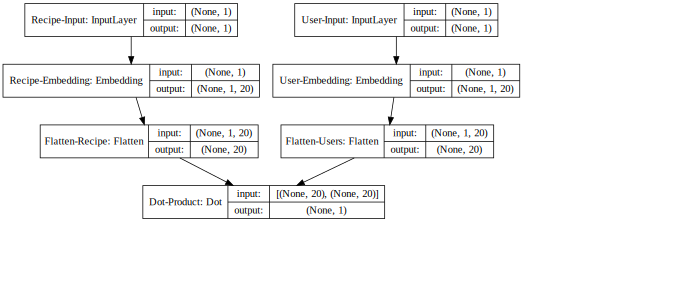

In [13]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [20]:
#model.summary()

In [15]:
y_hat = np.round(model.predict([test.user_id, test.recipe_id]),0)
y_true = test.rating

MAE = mean_absolute_error(y_true, y_hat)

percentage_wrong = MAE/1 * 100
percentage_wrong

MAE

0.10121712671158442

Text(0, 0.5, 'Train Error')

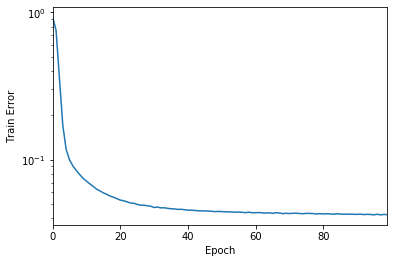

In [14]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")